# Проект по моделям машинного обучения с учителем (supervised learning) - Методы на основе деревьев

------
------

## ЦЕЛЬ: Создать модель предсказания того, уйдёт ли абонент в отток (churn).

----
----


## Часть 0: Импортируем библиотеки и загружаем данные


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../DATA/Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Часть 1: Общие характеристики данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


# Часть 2:  Исследование данных (Exploratory Data Analysis)

## Исследование признаков

In [8]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**Проверим сбалансированность значений колонки с классами (Churn).**

<Axes: xlabel='Churn', ylabel='count'>

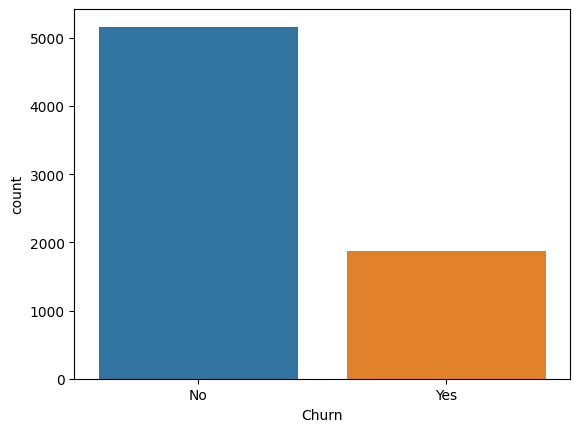

In [11]:
sns.countplot(x = df['Churn'], data = df)

<img src='fig1.png' >

<Axes: xlabel='Churn', ylabel='TotalCharges'>

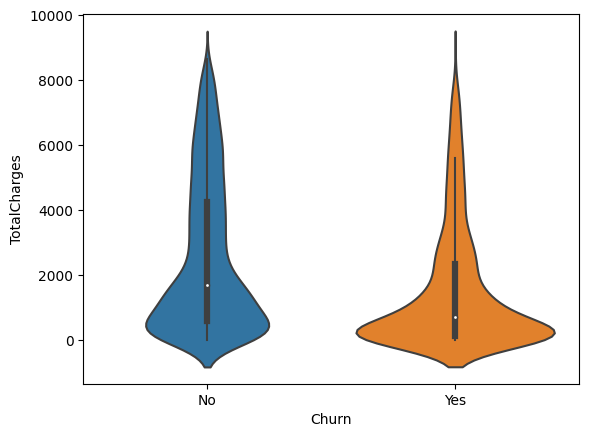

In [14]:
sns.violinplot(y = df['TotalCharges'], x = df['Churn'], data = df)

<img src='fig2.png' >

**Построим график boxplot с распределением колонки TotalCharges для различных типов контрактов с раскраской цветами по колонке Churn.**

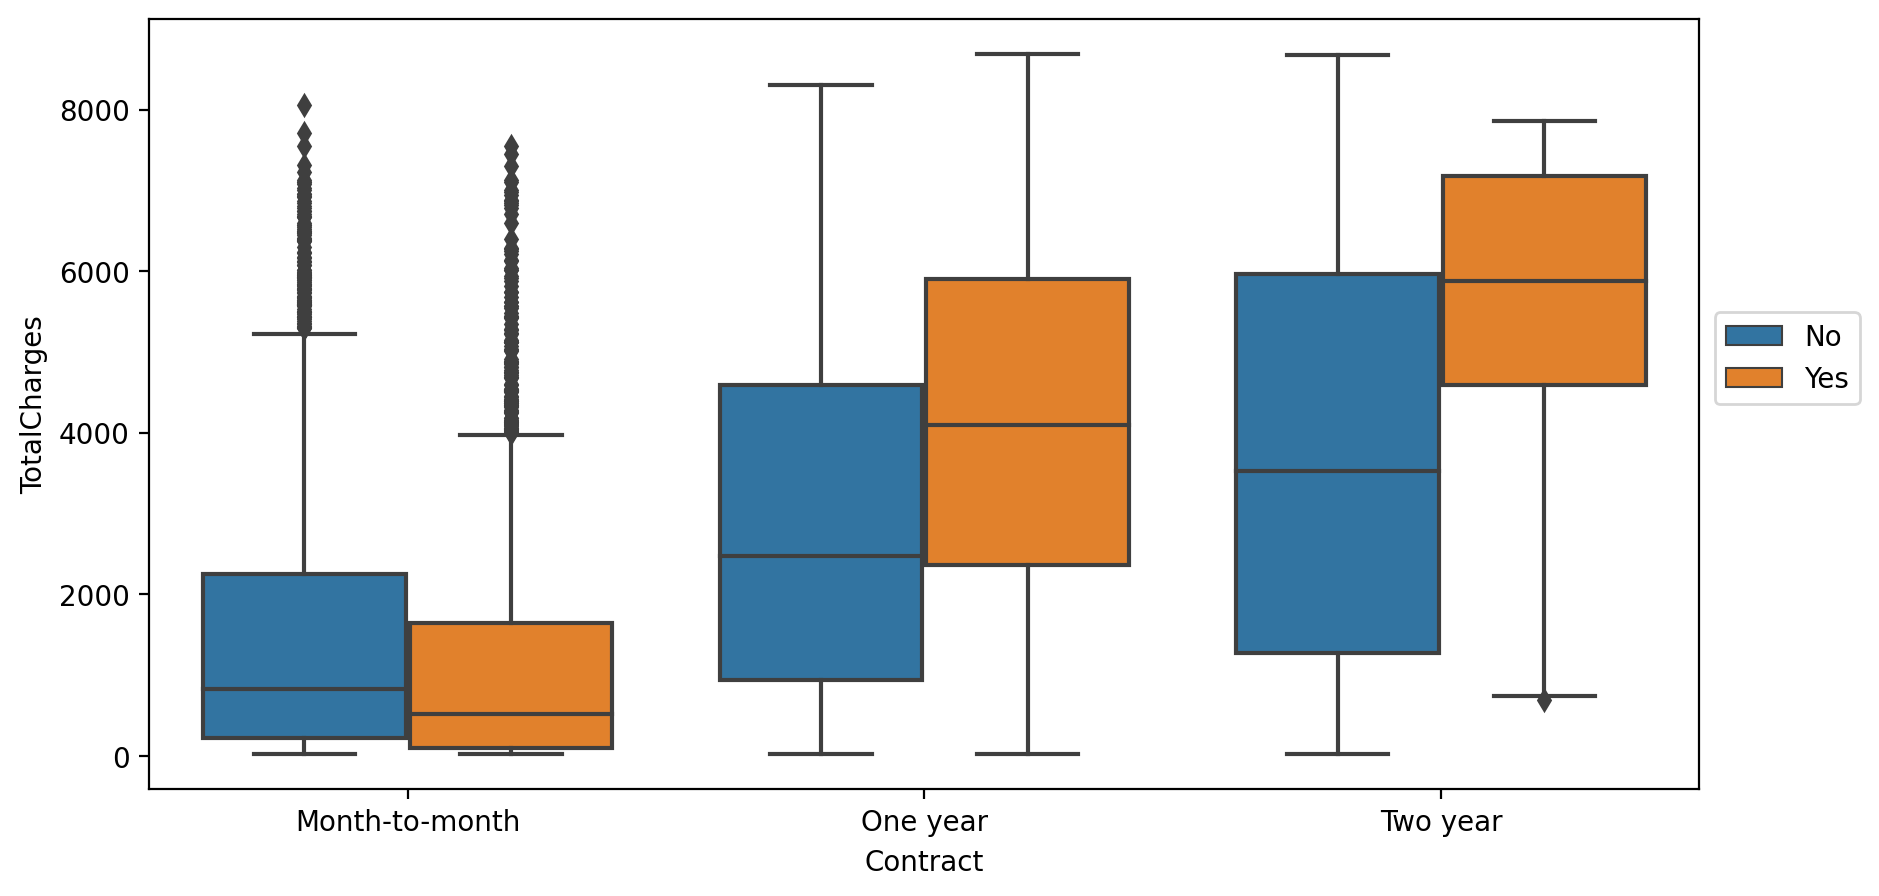

In [17]:
plt.figure(figsize = (10, 5), dpi = 200)
sns.boxplot(y = df['TotalCharges'], x = df['Contract'], data = df, hue = 'Churn')
plt.legend(loc = (1.01, 0.5))

<img src='fig3.png' >

In [36]:
corrdata = df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']]
corrdata = pd.get_dummies(corrdata)#, drop_first = True)

In [37]:
corrdata = pd.DataFrame(corrdata.corr().drop(['Churn_Yes', 'Churn_No'], axis = 0)['Churn_Yes'].sort_values())

In [42]:
corrdata = corrdata.reset_index().rename(columns = {'index' : 'features'})

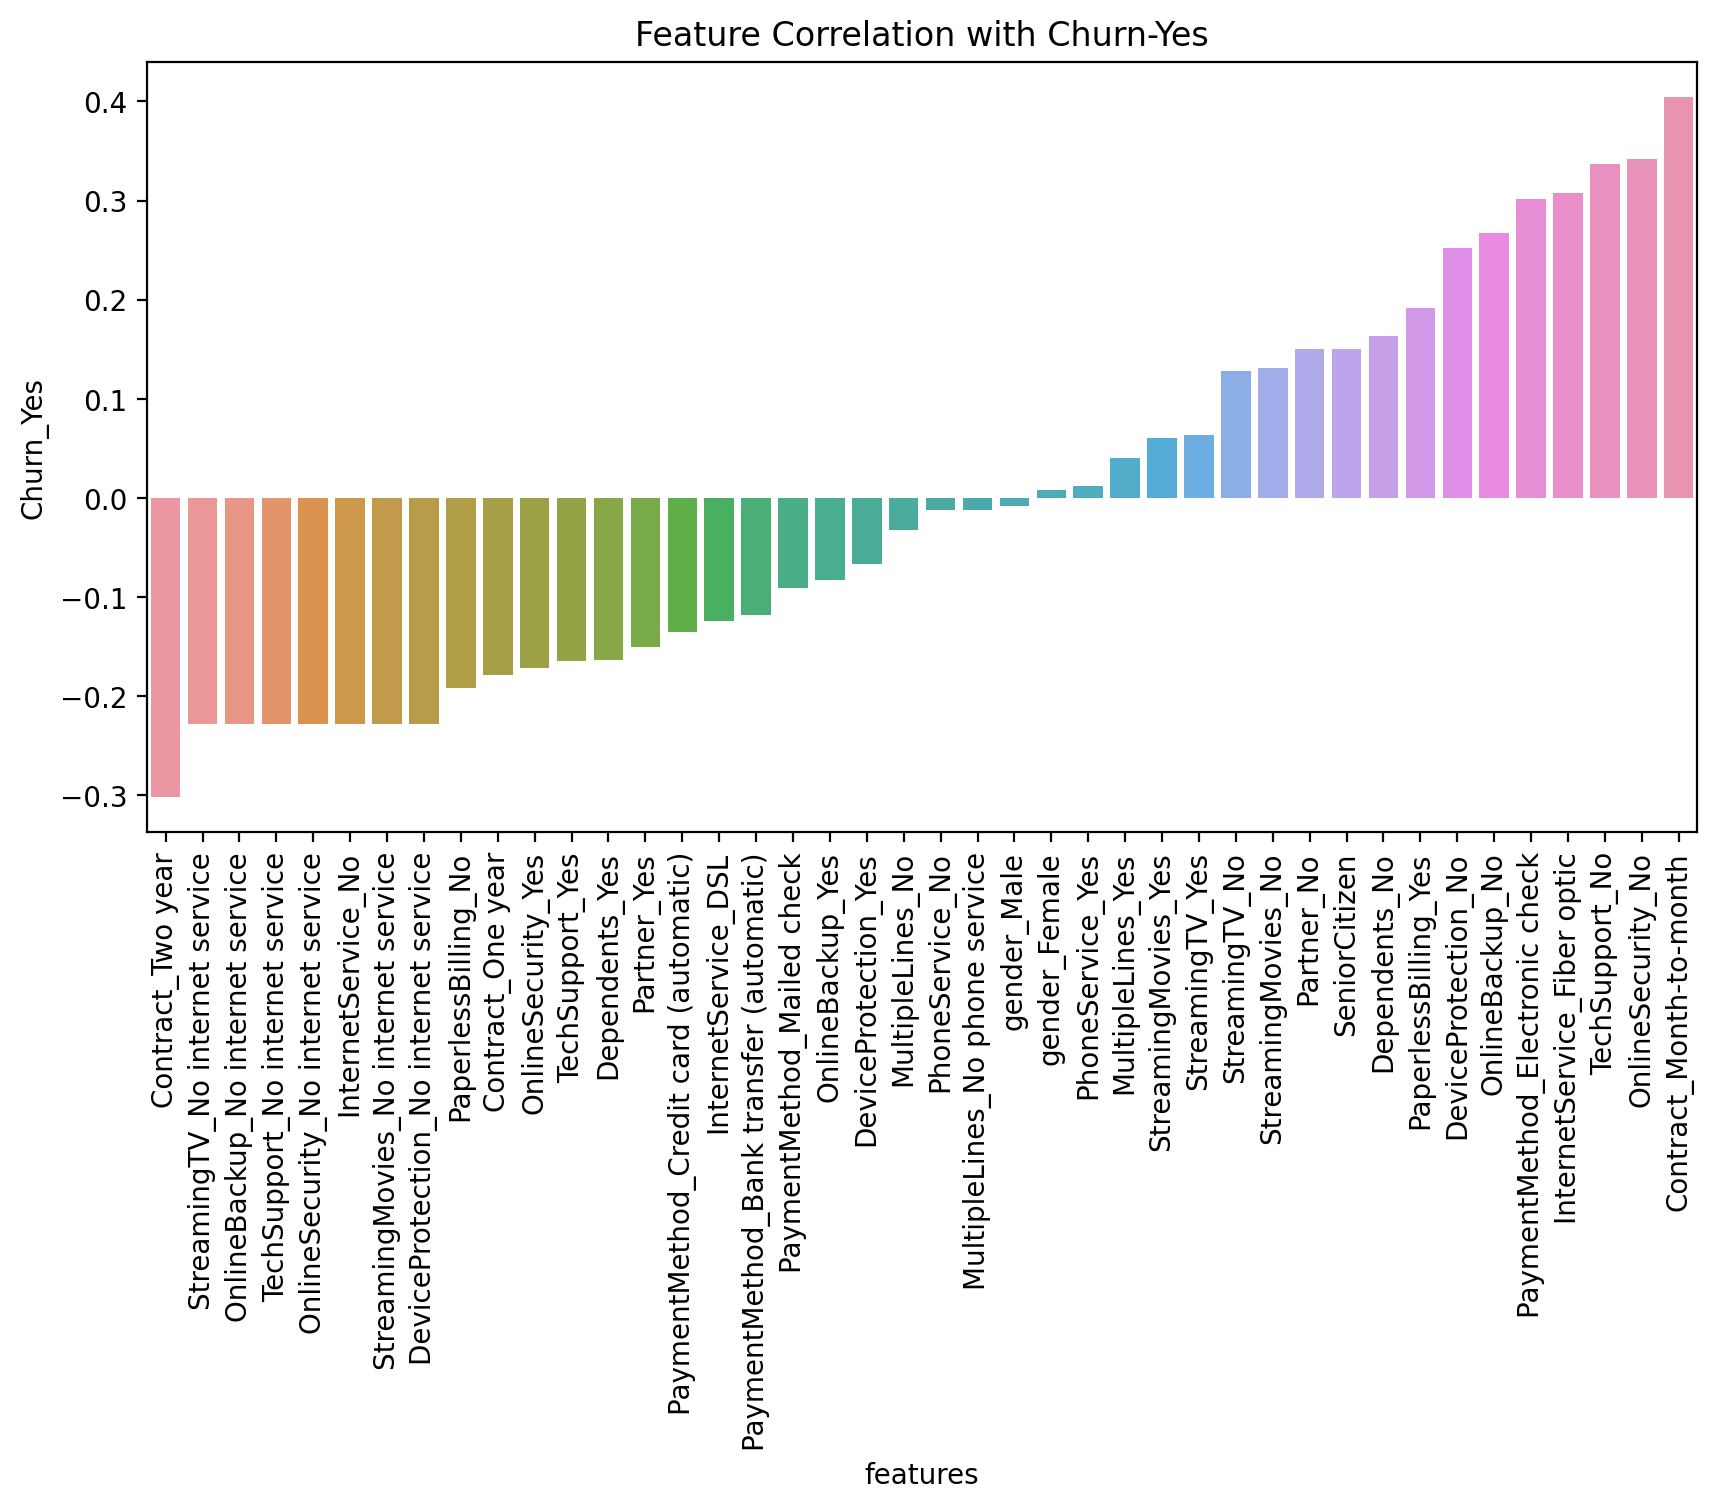

In [47]:
plt.figure(figsize = (10, 5), dpi = 200)
sns.barplot(x = corrdata['features'], y = corrdata['Churn_Yes'], data = corrdata)
plt.xticks(rotation = 90);
plt.title('Feature Correlation with Churn-Yes');

---
---

# Часть 3: Анализ оттока

**В этих заданиях мы выполним сегментацию абонентов на основе колонки tenure, создавая "когорты" и выполняя сравнение данных между различными когортами.**

In [48]:
df.Contract.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

**Создадим гистограмму с распределением значений колонки tenure - это количество месяцев, сколько времени человек является (или являлся) абонентом компании.**

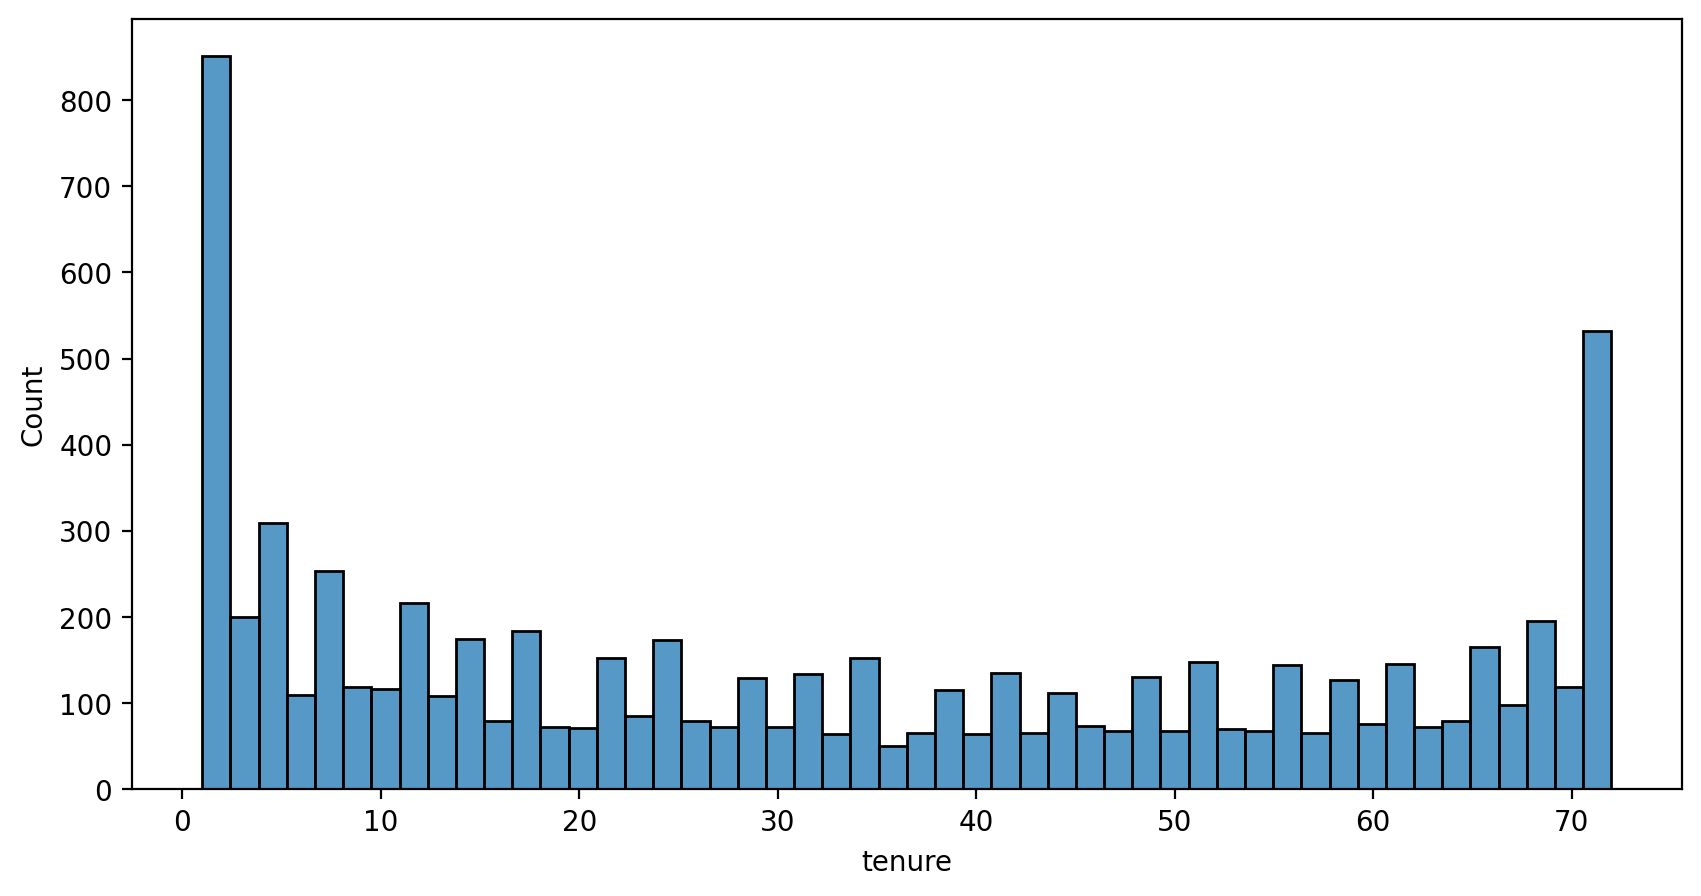

In [55]:
plt.figure(figsize = (10, 5), dpi = 200)
sns.histplot(x = df['tenure'], data = df, bins = 50);


<Figure size 2000x1000 with 0 Axes>

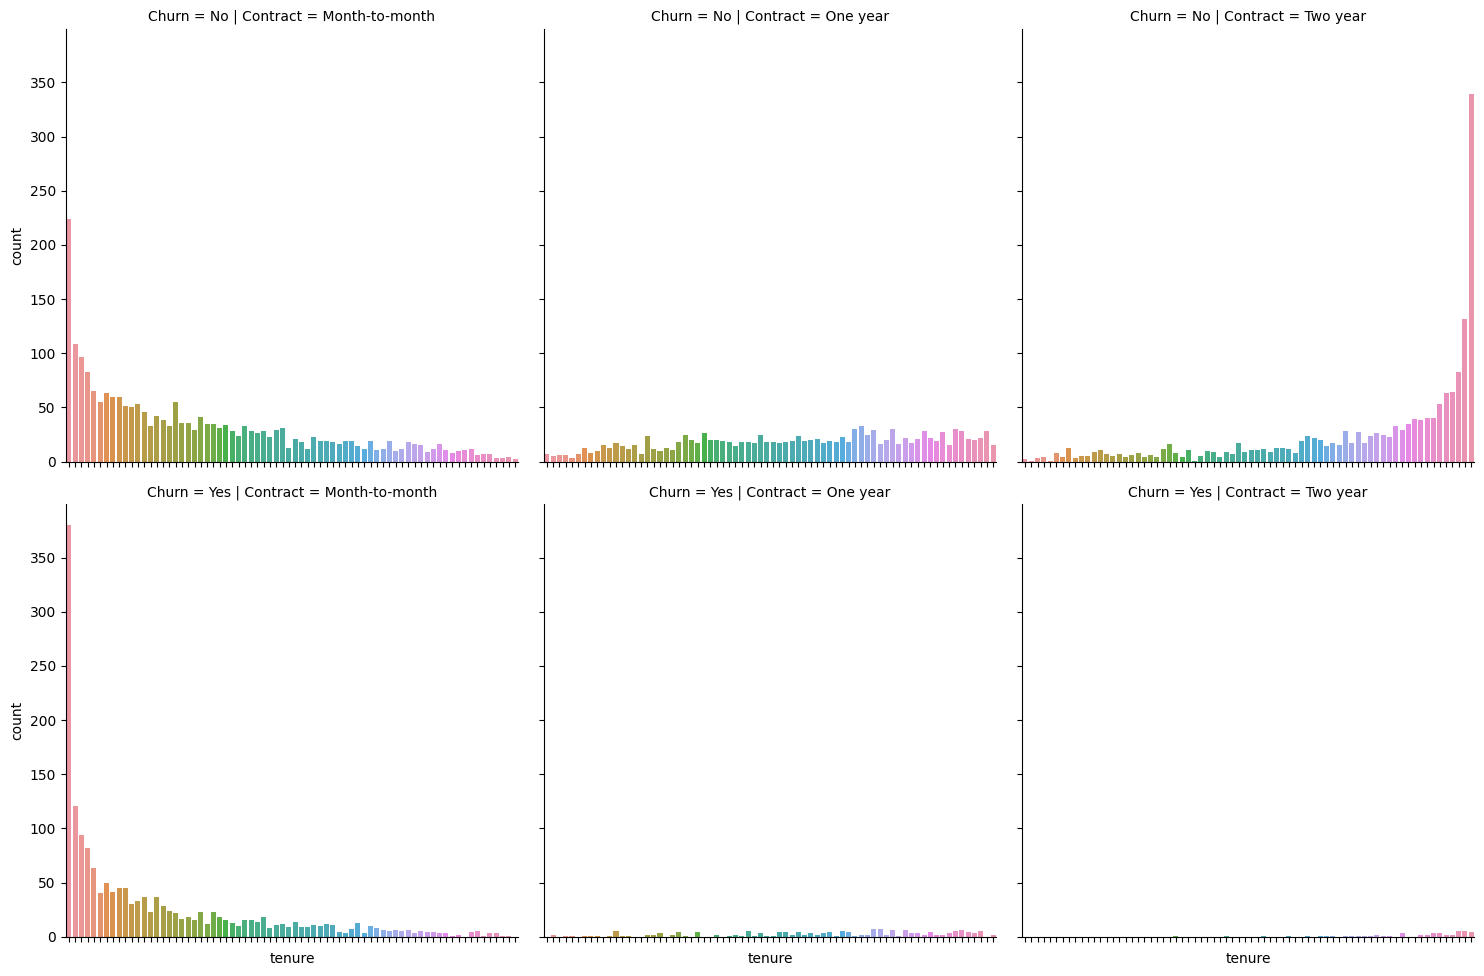

In [76]:
plt.figure(figsize = (10, 5), dpi = 200)
g = sns.catplot(x = 'tenure', data = df, kind = 'count', row = "Churn", col = 'Contract')
g.set_xticklabels()

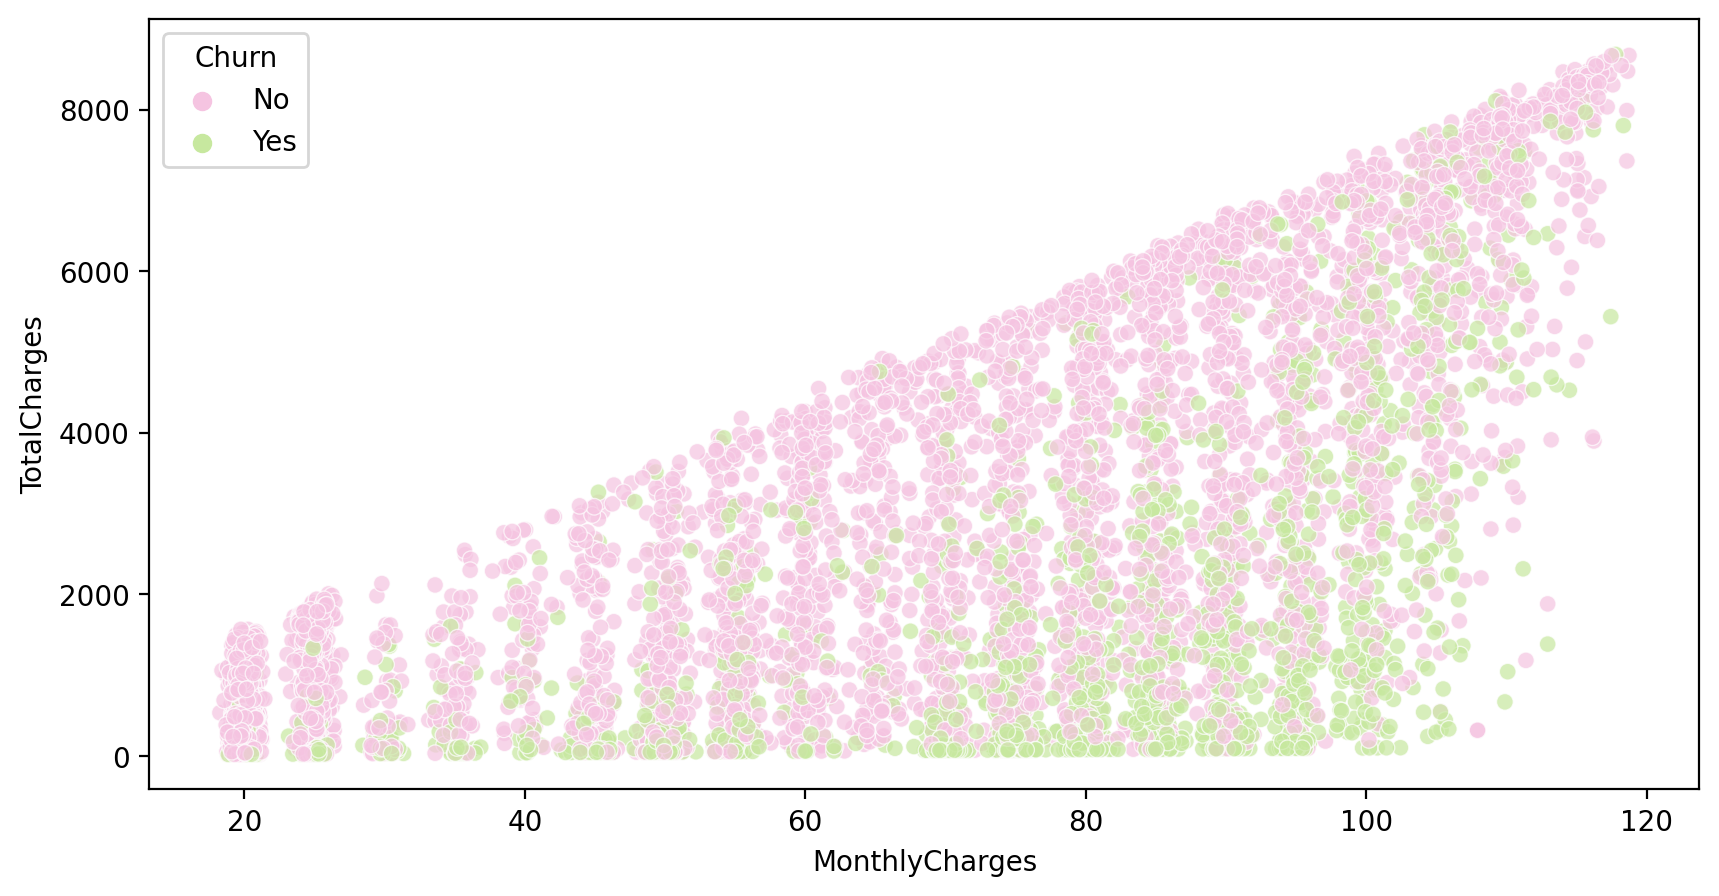

In [88]:
plt.figure(figsize = (10, 5), dpi = 200)
sns.scatterplot(x = 'MonthlyCharges', y = 'TotalCharges', data = df, hue = 'Churn', palette = 'PiYG', alpha = 0.7);

### Создание когорт (сегментов) по колонке Tenure

**Для начала поместим различные значения tenure (1 месяц, 2 месяца, 3 месяца и так далее) в отдельные когорты (сегменты).**

**Для каждого уникального значения колонки tenure в качестве когорты, вычислим процент оттока (churn rate) - это количество тех людей, кто ушёл в отток в когорте, как процент от общего количества людей в данной когорте.**

In [123]:
churn_rate = pd.DataFrame(df[df['Churn'] == 'Yes'].groupby(by = 'tenure').Churn.count() * 100/df.groupby(by = 'tenure').Churn.count())

In [124]:
churn_rate = churn_rate.reset_index().rename(columns = {'index' : 'tenure', 'Churn' : 'churn rate'})

**Построим график процента оттока для различных значений tenure.**

<Axes: xlabel='tenure', ylabel='churn rate'>

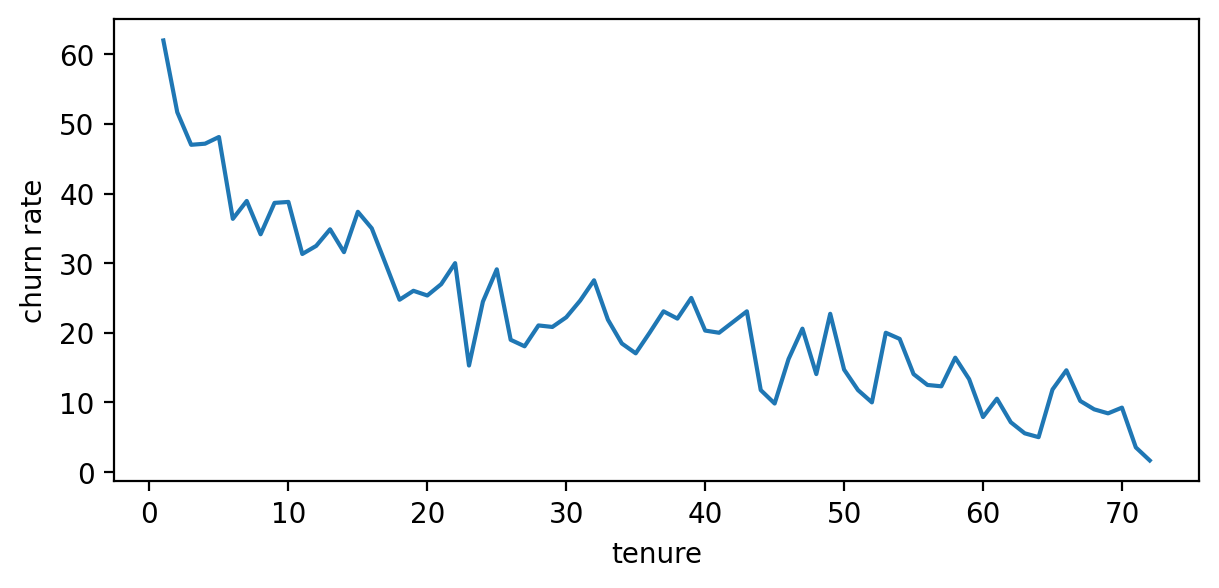

In [125]:
plt.figure(figsize = (7, 3), dpi = 200)
sns.lineplot(x = 'tenure', y = 'churn rate', data = churn_rate)

### Более крупные когорты (сегменты)
**Создадим новую колонку с названием "Tenure Cohort", в которой будут следующие 4 категории:**
   * '0-12 месяцев'
   * '24-48 месяцев'
   * '12-24 месяцев'
   * 'Более 48 месяцев'    

In [127]:
def make_cohorts(x):
    cohorts = ['0-12 months', '12-24 months', '24-48 months', 'over 48 months']
    if 1 <= x <= 12:
        return cohorts[0]
    elif 13 <= x <= 24:
        return cohorts[1]
    elif 25 <= x <= 48:
        return cohorts[2]
    else:
        return cohorts[3]

In [128]:
df['Tenure Cohort'] = df['tenure'].apply(lambda x: make_cohorts(x)) 

In [130]:
df[['tenure', 'Tenure Cohort']]

,tenure,Tenure Cohort
0,1,0-12 months
1,34,24-48 months
2,2,0-12 months
3,45,24-48 months
4,2,0-12 months
...,...,...
7027,24,12-24 months
7028,72,over 48 months
7029,11,0-12 months
7030,4,0-12 months


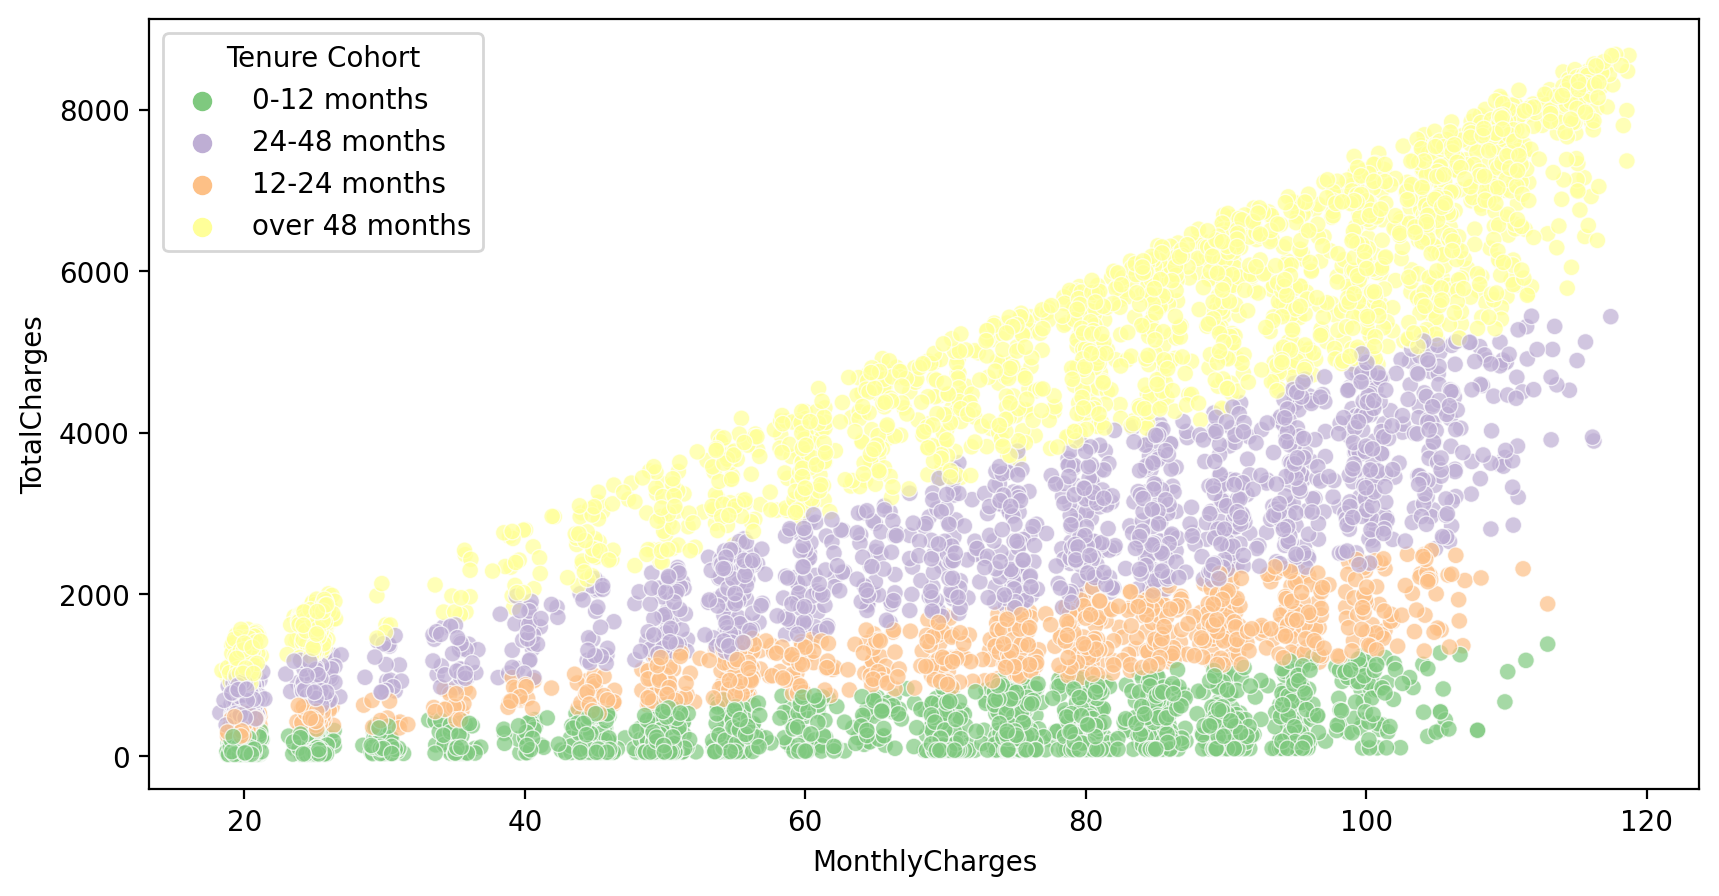

In [131]:
plt.figure(figsize = (10, 5), dpi = 200)
sns.scatterplot(x = 'MonthlyCharges', y = 'TotalCharges', data = df, hue = 'Tenure Cohort', palette = 'Accent', alpha = 0.7);


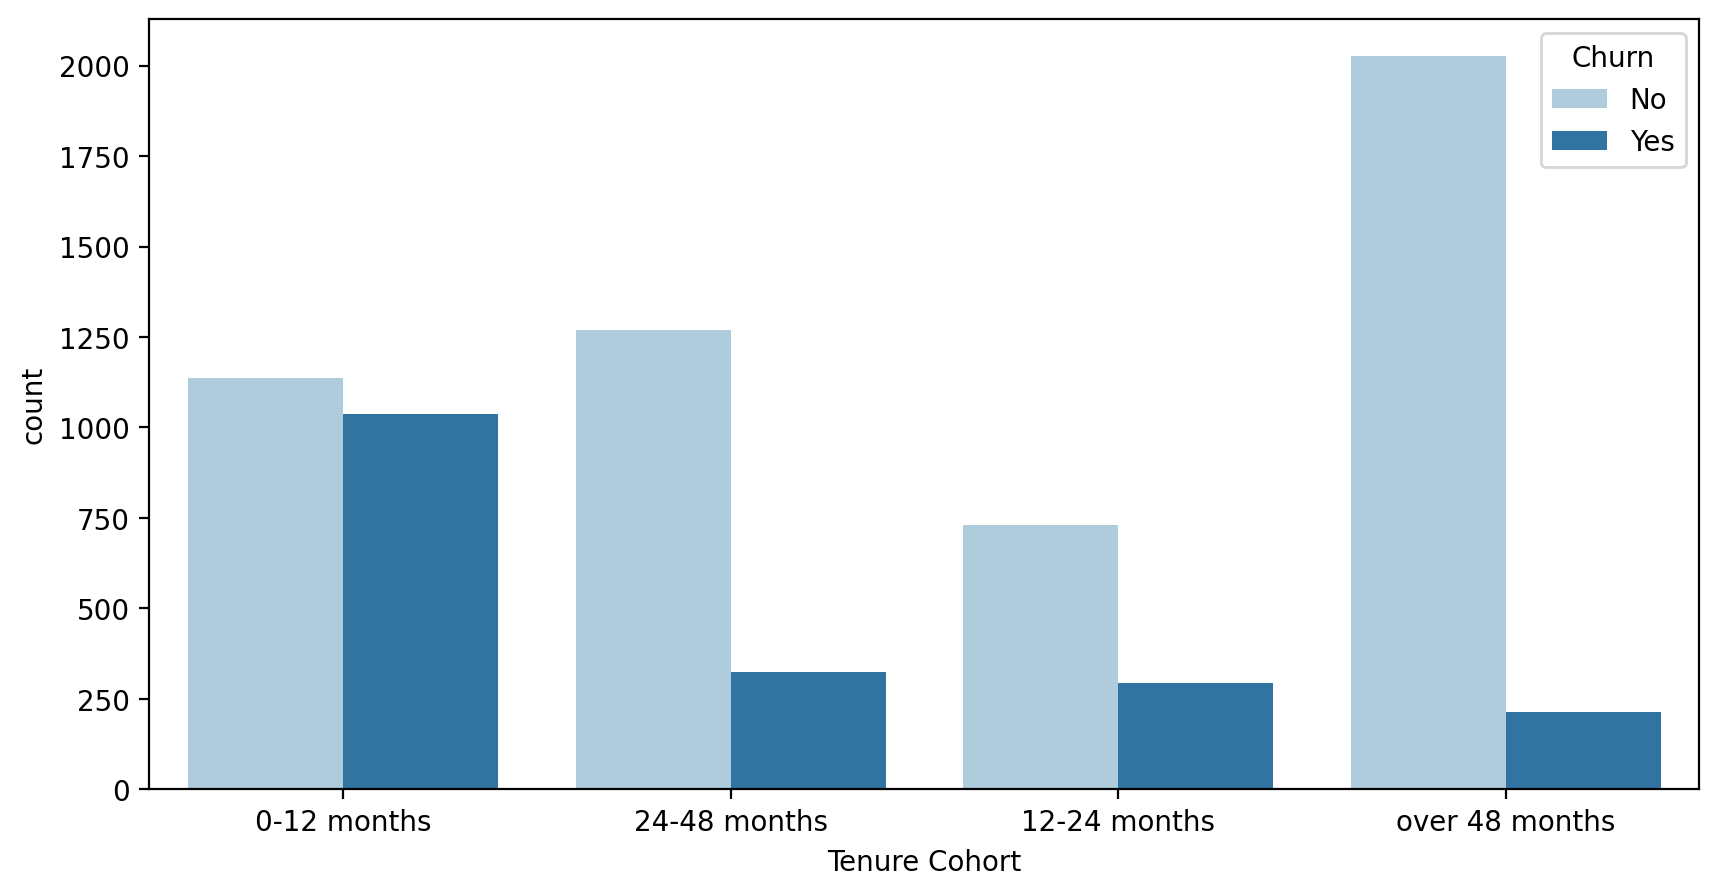

In [134]:
plt.figure(figsize = (10, 5), dpi = 200)
sns.countplot(x = 'Tenure Cohort', data = df, hue = 'Churn', palette = 'Paired');

<Figure size 2000x1000 with 0 Axes>

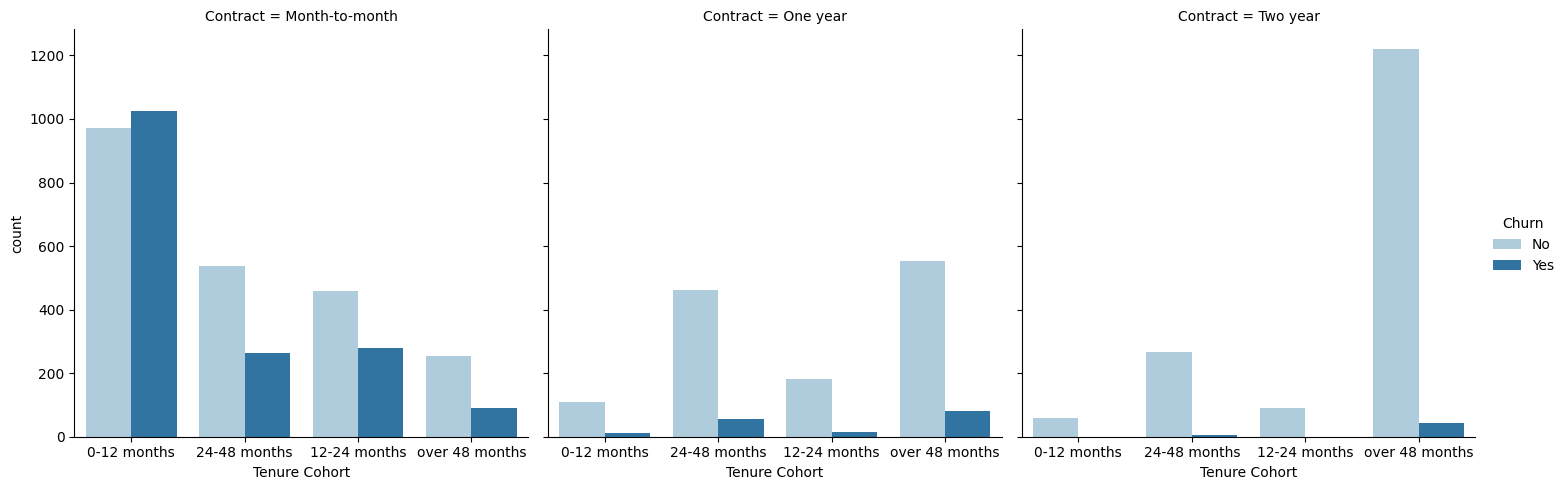

In [137]:
plt.figure(figsize = (10, 5), dpi = 200)
sns.catplot(x = 'Tenure Cohort', data = df, kind = 'count', col = 'Contract', hue = 'Churn', palette = 'Paired');

-----

# Часть 4: Предиктивная модель

**Исследуем 4 модели на основе деревьев: одно дерево решений, случайный лес, адаптивный бустинг и градиентный бустинг.**


## Одно дерево решений (Decision Tree)

In [152]:
def change(x):
    if x == 'No':
        return 0
    else:
        return 1

In [174]:
X = df.drop(['Churn', 'customerID'], axis = 1)
y = df['Churn'].apply(lambda x: change(x))

In [175]:
X = pd.get_dummies(X, drop_first = True)

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [176]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.1, random_state = 17)

In [160]:
from sklearn.model_selection import GridSearchCV

In [161]:
tree_clf = DecisionTreeClassifier()
params = {'max_depth' : range(1, 10), 'min_samples_split' : range(5, 55, 5), 'criterion' : ['gini', 'entropy']}
grid_model = GridSearchCV(estimator = tree_clf, param_grid = params, cv = 5)

In [177]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_split': range(5, 55, 5)})

In [178]:
y_pred = grid_model.best_estimator_.predict(X_test)

In [179]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       526
           1       0.55      0.48      0.51       178

    accuracy                           0.77       704
   macro avg       0.69      0.67      0.68       704
weighted avg       0.76      0.77      0.76       704



In [180]:
cm = confusion_matrix(y_test, y_pred)

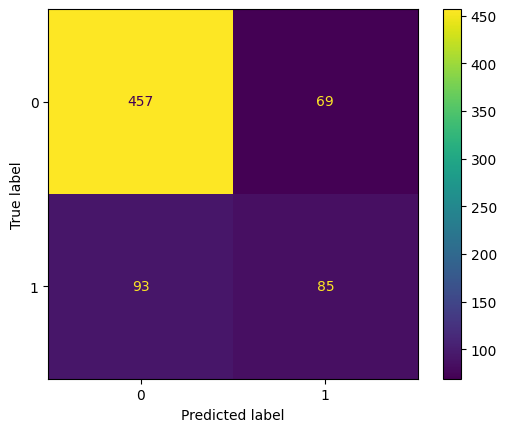

In [181]:
ConfusionMatrixDisplay(cm).plot()

In [182]:
fi_tree_clf = grid_model.best_estimator_.feature_importances_

In [183]:
fi_df = pd.DataFrame(data = {'Feature':X.columns, 'Importance' : fi_tree_clf})

In [185]:
fi_df = fi_df.sort_values(by = 'Importance')

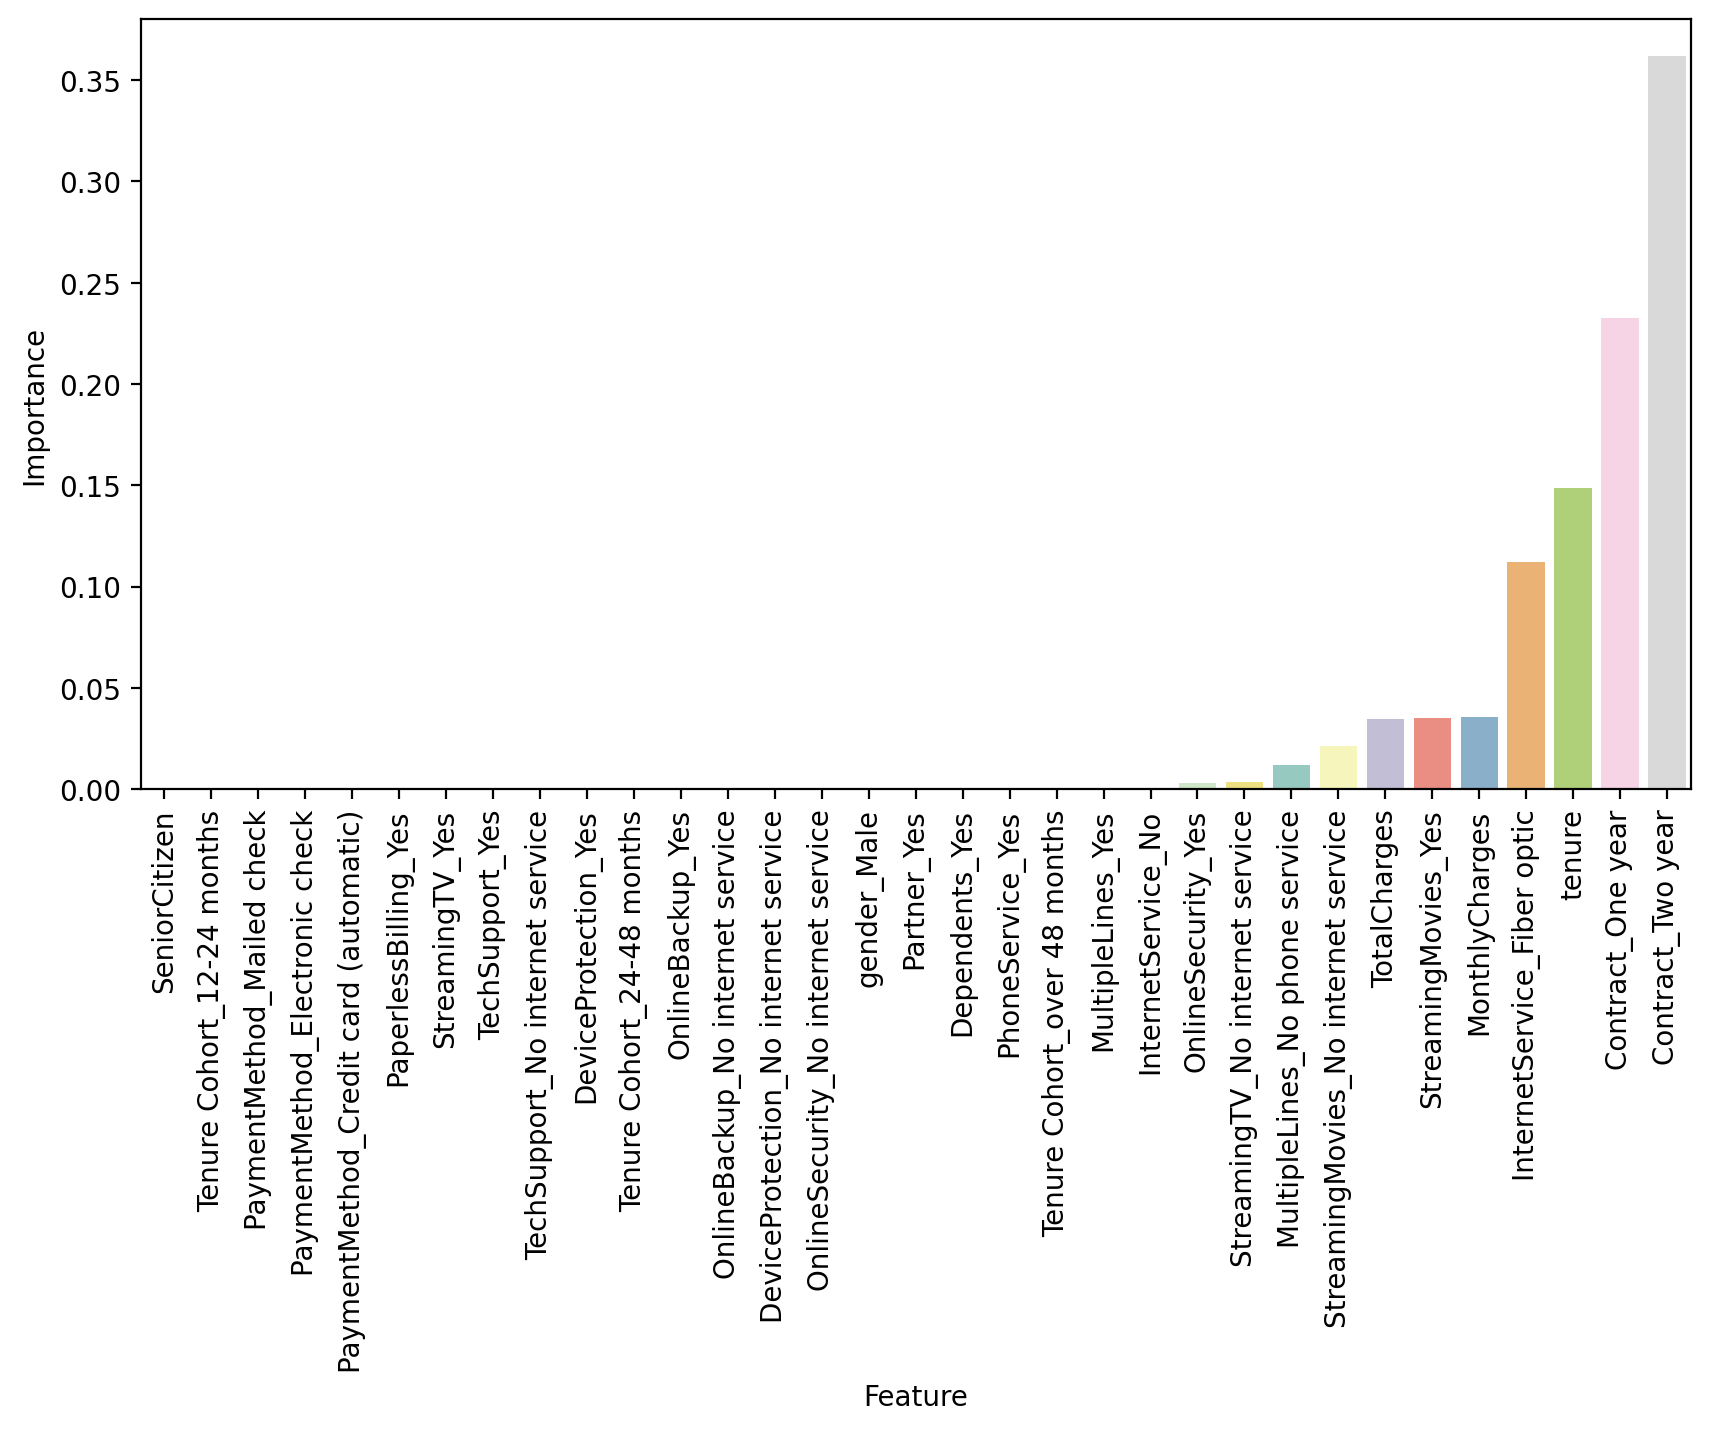

In [187]:
plt.figure(figsize = (10, 5), dpi = 200)
sns.barplot(x = 'Feature', y = 'Importance', data = fi_df, palette = 'Set3')
plt.xticks(rotation = 90);

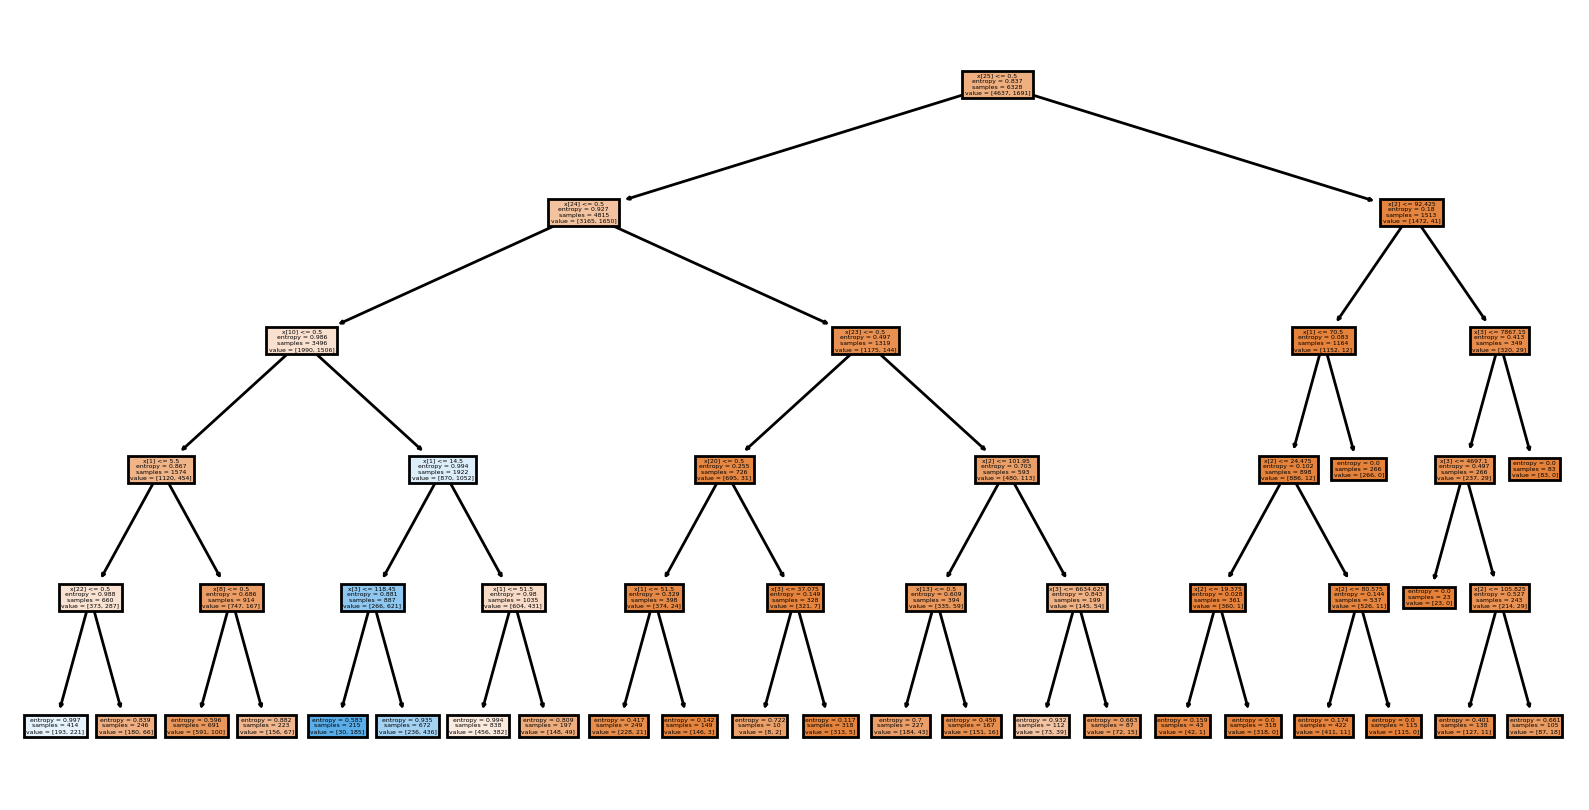

In [191]:
plt.figure(figsize = (10, 5), dpi = 200)
plot_tree(grid_model.best_estimator_, filled = True);

## Случайный лес (Random Forest)


In [194]:
rf_clf = RandomForestClassifier()
params = {'max_depth' : range(3, 10), 'n_estimators' : [10, 30, 50, 70, 100, 150, 200]}
grid_model = GridSearchCV(estimator = rf_clf, param_grid = params, cv = 5)

In [195]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(3, 10),
                         'n_estimators': [10, 30, 50, 70, 100, 150, 200]})

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       526
           1       0.61      0.53      0.57       178

    accuracy                           0.80       704
   macro avg       0.73      0.71      0.72       704
weighted avg       0.79      0.80      0.79       704



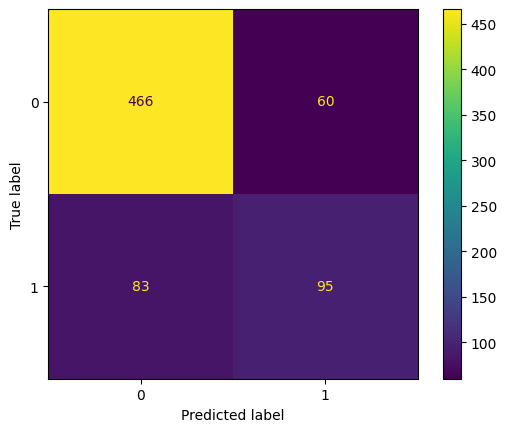

In [196]:
y_pred = grid_model.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [199]:
grid_model.best_params_

{'max_depth': 9, 'n_estimators': 100}

## Расширяемые деревья (Boosted Trees)

In [200]:
base = DecisionTreeClassifier(max_depth = 6)
aboost = AdaBoostClassifier(estimator = base)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       526
           1       0.49      0.49      0.49       178

    accuracy                           0.74       704
   macro avg       0.66      0.66      0.66       704
weighted avg       0.74      0.74      0.74       704



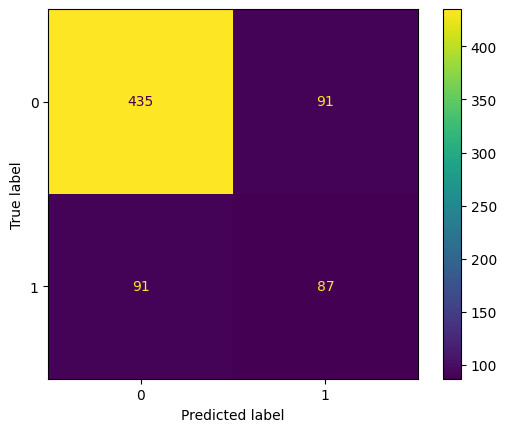

In [201]:
aboost.fit(X_train, y_train)
y_pred = aboost.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       526
           1       0.59      0.53      0.56       178

    accuracy                           0.79       704
   macro avg       0.72      0.71      0.71       704
weighted avg       0.78      0.79      0.79       704



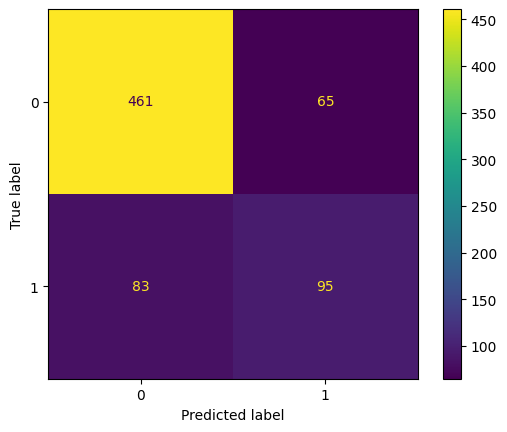

In [202]:
gboost = GradientBoostingClassifier(learning_rate = 0.3, max_depth = 5)
gboost.fit(X_train, y_train)
y_pred = gboost.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

**Исходя из полученных результатов, сравнивая метрику f1 score у разных моделей, можно сделать вывод, что лучше всего работают модели Случайного леса и Градиентного бустинга на деревьях решений. Однако, эта метрика все равно оказалась довольно низкой: это обуславливается в основном дисбалансом классов в исходных данных.**